# 02 - Pull out some reusable code, Standardize & Winsorize features

In this notebook I:
* Tuck away the download of data from kaggle into "dataset.py"
* Tuck away the loading of raw data into "dataset.py"
* I clean up the feature and label queries a bit - but I'll clean up more after creating more features
* Create a Winsorization Transformer
* Paragraphs for Winsorization, Standardization, Balancing (the training)
* Tuck away the evaluation into evaluate.py
* I'm going to wait to tuck away the back test ... I'm not yet how I want to do it

Note that Winsorization, Standardization, and Balancing had no impact on the model performance


In [6]:

import sys
import polars as pl
sys.path.append('../pipeline')
from dataset import CSVDataset, KaggleDataset
from evaluate import Evaluator


In [6]:
# kaggle_dataset = KaggleDataset()
# kaggle_dataset.load()

In [7]:
dataset = CSVDataset('../data/',["articles.csv","transactions_train.csv","customers.csv"])
dataset.load()


Loading ../data/articles.csv
Loading ../data/transactions_train.csv
Loading ../data/customers.csv



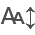

t_dat,customer_id,article_id,price,sales_channel_id
date,str,str,f64,i64
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…","""0663713001""",0.050831,2


In [7]:
query = '''
    SELECT *
    FROM transactions
    LIMIT 1
'''

swallow = dataset.run_query_display_results(query)

In [8]:
from datetime import date, timedelta

# Eventually I will be creating complex features so query will likely be generated
# and then there will be windows of responses and features as well
# I'm undecided at this point so I might simply put this in a class with three methods
# one to get features, one to get label, and one to get backtest

class QueryConstants:
    end_date=date(2020,9,22)
    feature_duration=365
    label_duration=30
    backtest_duration=30
    label_end =  end_date - timedelta(days=backtest_duration)
    feature_end = label_end - timedelta(days=label_duration)
    feature_start = feature_end - timedelta(days=feature_duration)

response_query = """
        SELECT
            t.customer_id,
            MAX(
                CASE
                    WHEN t.t_dat > DATE '{response_start}'  AND t.t_dat <= DATE '{response_end}'  THEN 1
                    ELSE 0
                END
            ) AS label
        FROM transactions t
        INNER JOIN customers c ON c.customer_id = t.customer_id
        GROUP BY t.customer_id
"""

feature_query = """
            SELECT
                t.customer_id
                ,COUNT(1) total_transaction_items
                ,MAX(t.t_dat) - DATE '{feature_end}' as days_since_last
                ,ROUND(590*SUM(price)) as total_revenue --See Kaggle compition news group regarding the 590 factor - todo: get link
                ,COUNT(DISTINCT t.t_dat) as total_transactions
            FROM transactions t
            WHERE t.t_dat <= DATE '{feature_end}' and t.t_dat > DATE '{feature_start}'
            GROUP BY t.customer_id
"""

label_query = response_query.format(response_start=QueryConstants.feature_end, response_end=QueryConstants.label_end)
backtest_response_query = response_query.format(response_start=QueryConstants.label_end, response_end=QueryConstants.end_date)

arrow_table = dataset.duckdb_conn.execute(label_query).fetch_arrow_table()
label_df = pl.from_arrow(arrow_table)

arrow_table = dataset.duckdb_conn.execute(backtest_response_query).fetch_arrow_table()
backtest_response_df = pl.from_arrow(arrow_table)

query = feature_query.format(**vars(QueryConstants))
arrow_table = dataset.duckdb_conn.execute(query).fetch_arrow_table()
feature_df = pl.from_arrow(arrow_table)





In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=0.01, upper_percentile=99.99):
        """
        Initialize the Winsorizer with percentiles for lower and upper bounds.

        Args:
            lower_percentile (float): The lower percentile for winsorization (e.g., 5 for 5th percentile).
            upper_percentile (float): The upper percentile for winsorization (e.g., 95 for 95th percentile).
        """
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.bounds_ = None  # To store computed bounds during fitting

    def fit(self, X, y=None):
        """
        Compute the lower and upper bounds for each feature in the data.

        Args:
            X (array-like): The input data (2D array).
            y (ignored): Not used, for compatibility with Scikit-learn API.
        """
        X = np.asarray(X)
        # Add debugging to check the shape of the input
        if X.ndim != 2:
            raise ValueError(f"Expected 2D input, got {X.ndim}D input with shape {X.shape}")

        # Compute bounds
        self.bounds_ = {}
        for col in range(X.shape[1]):
            self.bounds_[col] = {
                "lower": np.percentile(X[:, col], self.lower_percentile),
                "upper": np.percentile(X[:, col], self.upper_percentile),
            }
        return self

    def transform(self, X):
        """
        Apply winsorization to the data using the computed bounds.

        Args:
            X (array-like): The input data (2D array).

        Returns:
            np.ndarray: The winsorized data.
        """
        if self.bounds_ is None:
            raise ValueError("Winsorizer has not been fitted yet.")

        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError(f"Expected 2D input, got {X.ndim}D input with shape {X.shape}")

        # Apply winsorization
        X_winsorized = X.copy()
        for col, bounds in self.bounds_.items():
            X_winsorized[:, col] = np.clip(X[:, col], bounds["lower"], bounds["upper"])
        return X_winsorized


In [11]:
# preprocessing
# 1. Split train/test

from sklearn.model_selection import train_test_split

aligned_df = feature_df.join(label_df, on="customer_id")

display(aligned_df)

# Automatically separate features and labels
excluded_columns = ["customer_id", "label"]  # Columns to exclude
feature_columns = [col for col in aligned_df.columns if col not in excluded_columns]

# Split into features (X) and labels (y)
X = aligned_df.select(feature_columns).to_numpy()
y = aligned_df["label"].to_numpy()

# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(type(X_train))
print(X_train.shape)



customer_id,total_transaction_items,days_since_last,total_revenue,total_transactions,label
str,i64,i64,f64,i64,i32
"""89f7e53bfb9980de2db7ce66619b08…",24,-23,390.0,15,0
"""8b5b17919a59ad50321139e19961f2…",56,-26,905.0,12,1
"""8b94e9af812f8124cc26f82b684666…",40,-175,481.0,7,0
"""8bb56e9903254023c58a8bc5c67854…",15,-6,183.0,3,1
"""8bdd6fd94163e010e21bd68fb45558…",40,-33,376.0,14,0
…,…,…,…,…,…
"""7d231eed85ef7750f72e92a7f5cb66…",4,-5,24.0,1,0
"""868c7828bc15a16fe8dc7b5e853697…",2,-5,43.0,1,0
"""9f2b2612be1f261a9a1f14d4e1213a…",1,-5,20.0,1,0


<class 'numpy.ndarray'>
(787288, 4)


In [12]:
# Winsorize for extreme values

winsorizer = Winsorizer(lower_percentile=1, upper_percentile=99)

winsorizer.fit(X_train)

print(winsorizer.bounds_)
X_train_winsorized = winsorizer.transform(X_train)






{0: {'lower': 1.0, 'upper': 105.0}, 1: {'lower': -356.0, 'upper': 0.0}, 2: {'lower': 8.0, 'upper': 1892.0}, 3: {'lower': 1.0, 'upper': 25.0}}


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

standard_scaler.fit(X_train_winsorized)

X_train_standardized = standard_scaler.transform(X_train_winsorized)

print(standard_scaler.mean_)
print(standard_scaler.scale_)

[  14.69248483 -110.51150786  240.37010344    4.27733434]
[ 18.72606047 101.59556473 327.65016011   4.65216447]


In [14]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)  # Initialize SMOTE
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_standardized, y_train)
print(X_train_standardized.shape)
print(X_train_balanced.shape)
print(y_train_balanced.shape)

(787288, 4)
(1228250, 4)
(1228250,)


In [15]:
# training - cut and paste for now

import polars as pl

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# model = LogisticRegression()
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)


model.fit(X_train_balanced, y_train_balanced)

# # Compute AUC for training set
y_train_prob = model.predict_proba(X_train_balanced)[:, 1]  # Probabilities for the positive class
train_auc = roc_auc_score(y_train_balanced, y_train_prob)
#
print(train_auc)







0.7829867529542847


Computing optimal Threshold: 0.37
Computing predictions...
AUC: 0.78
Optimal Threshold: 0.37
Maximum F1 Score: 0.73
              precision    recall  f1-score   support

           0       0.78      0.54      0.64    614125
           1       0.65      0.85      0.73    614125

    accuracy                           0.69   1228250
   macro avg       0.71      0.69      0.69   1228250
weighted avg       0.71      0.69      0.69   1228250



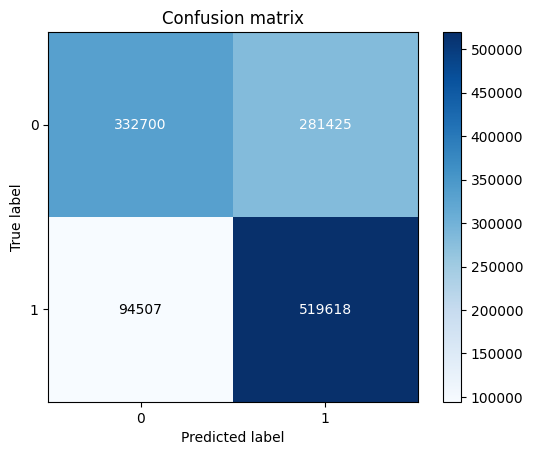

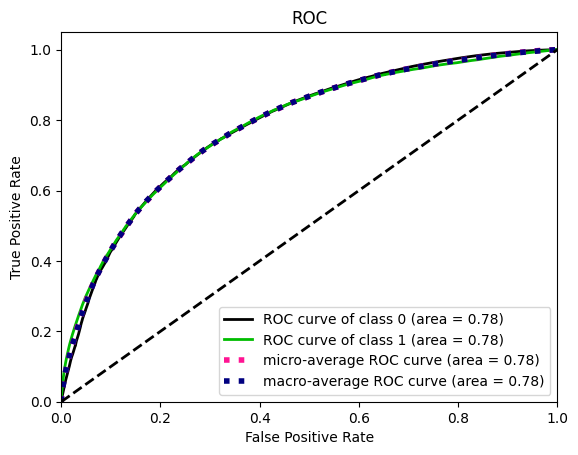

In [16]:
e_train = Evaluator(y_train_balanced, y_train_prob)
e_train.display_results()

In [17]:
# score the test

X_test_winsorized = winsorizer.transform(X_test)
X_test_standardized = standard_scaler.transform(X_test_winsorized)
y_test_prob_both = model.predict_proba(X_test_standardized)
y_test_prob = y_test_prob_both[:, 1]  # Probabilities for the positive class

Computing optimal Threshold: 0.52
Computing predictions...
AUC: 0.78
Optimal Threshold: 0.52
Maximum F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.89      0.74      0.81    153531
           1       0.43      0.68      0.52     43291

    accuracy                           0.73    196822
   macro avg       0.66      0.71      0.67    196822
weighted avg       0.79      0.73      0.75    196822



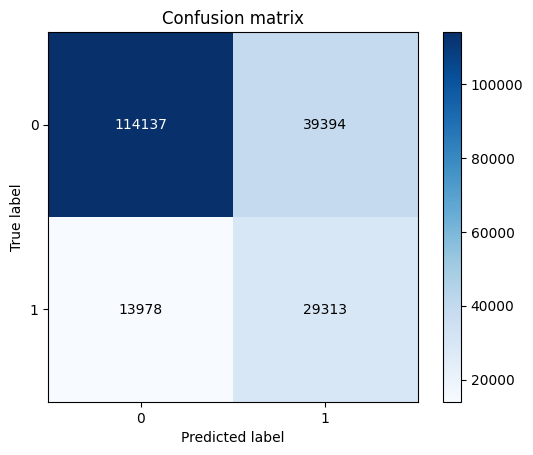

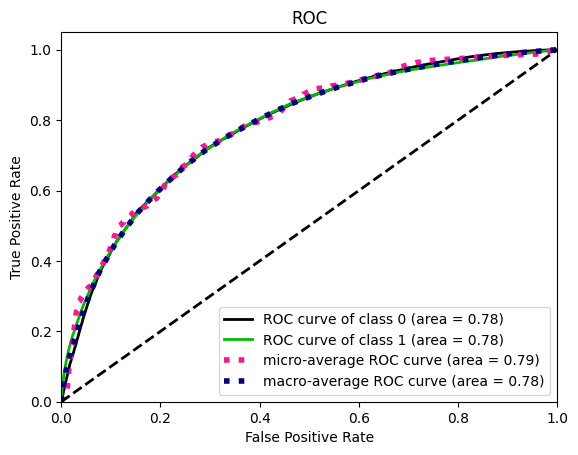

In [18]:
e_test = Evaluator(y_test, y_test_prob_both)
e_test.display_results()



In [19]:

end_date = date(2020,9,22)
feature_duration = 365
backtest_duration = 30
label_duration = 0
label_end =  end_date - timedelta(days=backtest_duration)
feature_end = label_end - timedelta(days=label_duration)
feature_start = feature_end - timedelta(days=feature_duration)


display("Initial feature_start: ", feature_start)
display("Initial feature_end: ", feature_end)
# print()

# this is nice ... I get features by just providing start and end
backtest_feature_query = feature_query.format(feature_end=feature_end, feature_start=feature_start)

# todo this is where dataset.run_query(query) would be good.  Returns DF.
arrow_table = dataset.duckdb_conn.execute(backtest_feature_query).fetch_arrow_table()
backtest_feature_df = pl.from_arrow(arrow_table)

# todo: I do not use this view
# dataset.duckdb_conn.register("backtest_features", backtest_feature_df)

print(backtest_feature_df.shape)

# I'm preparing to score records ... for scoring I think ...
# def score(model, feature_df, pk_column) and returns something reasonable .. meaning I want to return
# a dataframe with customer_id, probability (or all classes to generalize to multi-class)
# and maybe evaluation could have a different constructor that takes a DF instead?

features_without_id = backtest_feature_df.drop("customer_id")

print(features_without_id.shape)

features_without_id_winsorized = winsorizer.transform(features_without_id.to_numpy())
features_without_id_standard = standard_scaler.transform(features_without_id_winsorized)

scores_prob_positive = model.predict_proba(features_without_id_standard)[:, 1]
backtest_pred = [1 if prob >= e_test.optimal_threshold else 0 for prob in scores_prob_positive]

scores_df = pl.DataFrame({
    "customer_id": backtest_feature_df["customer_id"],
    "score": scores_prob_positive,
    "prediction": backtest_pred
})

dataset.duckdb_conn.register("scores", scores_df)

backtest_pred_truth_df = scores_df.join(backtest_response_df, on="customer_id")
backtest_response = np.array(backtest_pred_truth_df["label"])
backtest_score = np.array(backtest_pred_truth_df["score"])






'Initial feature_start: '

datetime.date(2019, 8, 24)

'Initial feature_end: '

datetime.date(2020, 8, 23)

(985282, 5)
(985282, 4)


Computing predictions...
AUC: 0.78
Optimal Threshold: 0.52
Maximum F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.89      0.74      0.81    772290
           1       0.42      0.67      0.52    212992

    accuracy                           0.73    985282
   macro avg       0.66      0.71      0.66    985282
weighted avg       0.79      0.73      0.75    985282



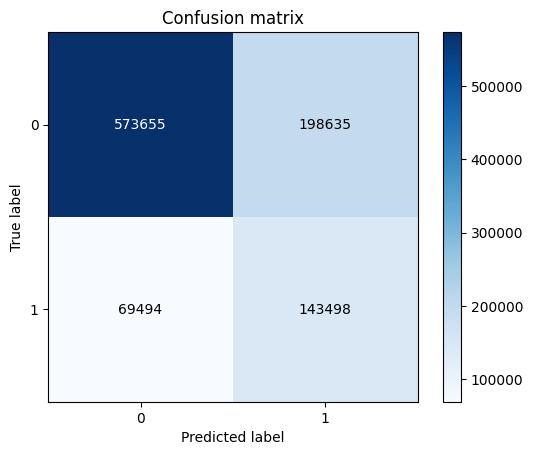

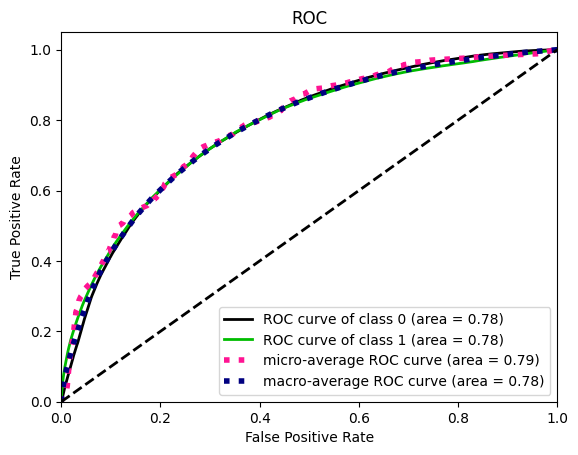

In [20]:
e_backtest = Evaluator(backtest_response, backtest_score, threshold=e_test.optimal_threshold)

e_backtest.display_results()


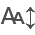

decile,buyer_count,scored_customer_count,non_buyer_count
i64,"decimal[38,0]",i64,"decimal[38,0]"
10,4896,98528,93632
9,5390,98528,93138
8,6762,98528,91766
7,9979,98528,88549
6,13236,98528,85292
5,17651,98528,80877
4,23297,98528,75231
3,29890,98528,68638
2,40079,98529,58450


In [21]:
# todo this is where I want to encapsulate the display of response curve ??? or do I care
# the display can be encapsulated ... but perhaps the computatiopn of DF still stays
# in notebook for now

query = f'''

SELECT decile, SUM(bought) buyer_count, COUNT(1) scored_customer_count, COUNT(1) - SUM(bought) non_buyer_count
FROM (
    SELECT s.customer_id, ntile(10) OVER (ORDER BY score desc) AS decile, COALESCE(bought,0) as bought
    from scores s
    left outer join (
        SELECT customer_id, COUNT(distinct t.customer_id) bought
        from transactions t
        WHERE t_dat > DATE '{feature_end}'
        GROUP BY customer_id
    ) t on t.customer_id = s.customer_id
    GROUP BY s.customer_id, score, bought
) x
GROUP BY decile
ORDER BY decile DESC
'''

backtest_results = dataset.run_query_display_results(query)
# backtest - use the new features and labels code I think firstly
# scoring ... leave this open for now

# I can use the feature query constant and set the correct parameters to get the backtest features

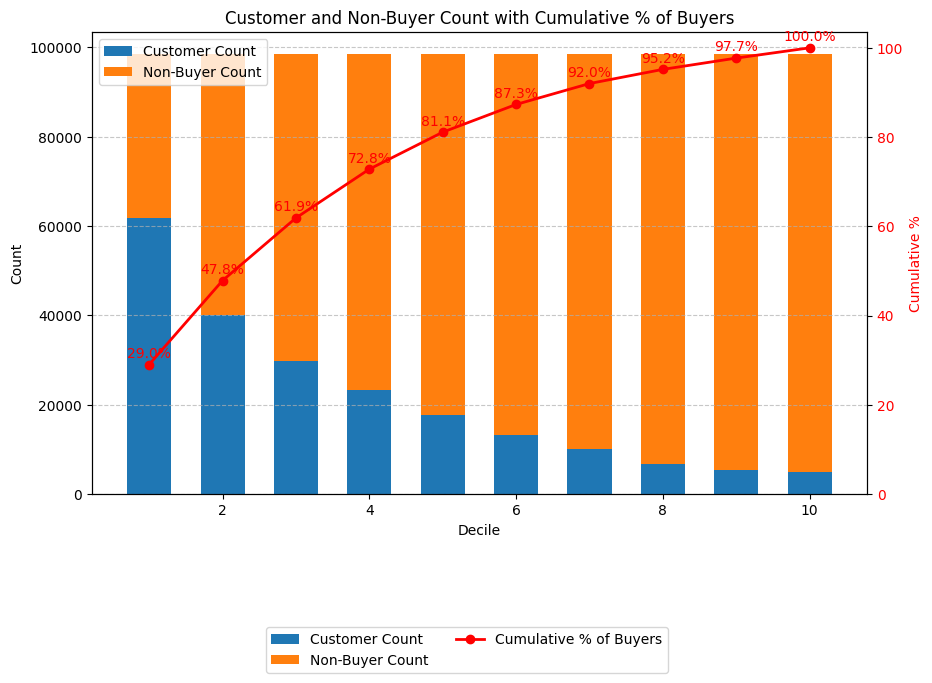

In [22]:


# plot the response curve ... put into a class
import matplotlib.pyplot as plt

# Assuming data is already created
data = backtest_results.to_pandas()

# Sort the DataFrame by decile in ascending order
data = data.sort_values(by="decile", ascending=True)

data["cumulative_percent"] = (data["buyer_count"].cumsum() / data["buyer_count"].sum() * 100)

# Extract columns as lists
decile = data["decile"].to_list()
customer_count = data["buyer_count"].to_list()
non_buyer_count = data["non_buyer_count"].to_list()
cumulative_percent = data["cumulative_percent"].to_list()

# print(cumulative_percent)
# print(customer_count)

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
ax1.bar(decile, customer_count, label="Customer Count", width=0.6)
ax1.bar(decile, non_buyer_count, bottom=customer_count, label="Non-Buyer Count", width=0.6)

# Label for the primary y-axis
ax1.set_xlabel('Decile')
ax1.set_ylabel('Count')
ax1.set_title('Customer and Non-Buyer Count with Cumulative % of Buyers')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc="upper left")

# Create a secondary y-axis for cumulative percent
ax2 = ax1.twinx()
ax2.plot(decile, cumulative_percent, color="red", marker="o", label="Cumulative % of Buyers", linewidth=2)
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for x, y in zip(decile, cumulative_percent):
    ax2.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color="red")

# Set the secondary y-axis to start at 0
ax2.set_ylim(0, ax2.get_ylim()[1])  # Start from 0, keep the max limit as it is


# Combine legends from both axes
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.show()

# this is not yet how I want it to look but will need to do for the time being